# Cats vs Dogs classifier from finetuning VGG using AWS



This is my personal project for week1 of the fast.ai online course. The helper files (utils.py, vgg16.py) are from the course, and were not written by me. 

This is my first project using AWS. I'm using a p2.xlarge EC2 instance for final training (GPU accelerated) and a t.large EC2 instance for initial coding and testing. I figured out how to have a single EBS storage volume shared between the two instances, so I could easily do the work without incurring any more costs than necessary. I set up some aliases in bash to help keep my workflow simple.

Here is some of the bash code I used to help with my workflow:

In [ ]:
#helper functions to detach and re-attach the EBS drive to a given $instanceID
alias aws-attach-volume='aws ec2 attach-volume --volume-id vol-066be34ab5d5cf07c --instance-id $instanceId --device /dev/sda1'
alias aws-detach-volume='aws ec2 detach-volume --volume-id vol-066be34ab5d5cf07c'

#get the instanceID for my two instances. 
alias aws-get-p2='export instanceId=`aws ec2 describe-instances --filters "Name=instance-state-name,Values=stopped,Name=instance-type,Values=p2.xlarge" --query "Reservations[0].Instances[0].InstanceId"` && echo $instanceId'
alias aws-get-t2='export instanceId=`aws ec2 describe-instances --filters "Name=instance-state-name,Values=stopped,Name=instance-type,Values=t2.large" --query "Reservations[0].Instances[0].InstanceId"` && echo $instanceId'

#start up the $instanceID. Before starting, I detach the EBS instance, and attach it to the instance I'm booting up.
alias aws-start='aws-detach-volume && aws-attach-volume && aws ec2 start-instances --instance-ids $instanceId && aws ec2 wait instance-running --instance-ids $instanceId && export instanceIp=`aws ec2 describe-instances --filters "Name=instance-id,Values=$instanceId" --query "Reservations[0].Instances[0].PublicIpAddress"` && echo $instanceIp'
#helper function to get the current instance IP
alias aws-ip='export instanceIp=`aws ec2 describe-instances --filters "Name=instance-id,Values=$instanceId" --query "Reservations[0].Instances[0].PublicIpAddress"` && echo $instanceIp'
#function to ssh into the instance once it's running
alias aws-ssh='ssh -i ~/.ssh/aws-key-fast-ai.pem ubuntu@$instanceIp'
#stop the instance. 
alias aws-stop='aws ec2 stop-instances --instance-ids $instanceId'
#see if an instance is running/stopped. 
alias aws-state='aws ec2 describe-instances --instance-ids $instanceId --query "Reservations[0].Instances[0].State.Name"'

#helper functions for downloading files from the remote EC2 instance to the local computer. I left room for flags 
#so I could use -r in particular. 
aws-scp-to () {
    scp -i ~/.ssh/aws-key-fast-ai.pem $3 $PWD/$1 ubuntu@$instanceIp:~/$2
}

aws-scp-from () {
    scp -i ~/.ssh/aws-key-fast-ai.pem $2 ubuntu@$instanceIp:~/$1 $PWD
}

This is my first Kaggle Submission. The dogs vs cats contest has 25,000 labeled images to train on, and 12,500 unlabeled training images for generating the final submission. I split up the labeled training data into cats and dogs folders, witholding 20% (2,500 cats, and 2,500 dogs) for use in the validation set. I also created a 'sample' folder with the same directory structure, for testing and writing my code from within the t2.large instance. The sample folder has a training dataset of 100 cats and 100 dogs, and a validation dataset with 50 cats and 50 dogs. This was a small enough number to have roughly real time workflow while testing my code. 

The first cell is the code I used to programmatically generate the train/valid/sample directories. 

In [2]:
import os
import random
import shutil

train_path = 'kaggle/train/'
valid_path = 'kaggle/valid/'
sample_train = 'kaggle/sample/valid/'
sample_valid = 'kaggle/sample/train/'
subfolders = ['cats', 'dogs']

def make_directory_structure(subfolders):
    for sub in subfolders:
        if not os.path.isdir(train_path+sub):
            os.makedirs(train_path+sub)
        if not os.path.isdir(valid_path+sub):
            os.makedirs(valid_path+sub)
        if not os.path.isdir(sample_train+sub):
            os.makedirs(sample_train+sub)
        if not os.path.isdir(sample_valid+sub):
            os.makedirs(sample_valid+sub)

    
def split_cats_and_dogs():
"""every file starts with either 'cat' or 'dog' so I take the first 
three letters and add an s to get the destination subfolder."""
    files = os.listdir(train_path)
    for f in files:
        shutil.move(os.path.join(train_path, f), os.path.join(train_path, f[:3]+'s'))

        
def train_val_split(folder, num = 0):
    path = os.path.join('kaggle/train', folder)
    dest = os.path.join('kaggle/valid', folder)
    files = os.listdir(path)
    validation_size = int(len(files)*.2)
    for f in random.sample(files, validation_size):
        shutil.move(os.path.join(path,f), dest)
        
        
def build_sample_directory():
    folders = {'train': 100, 'valid': 50}
    
    for folder, count in folders.items():
        for sub in subfolders:
            src = os.path.join(os.path.join('kaggle', folder), sub)
            dest = os.path.join(os.path.join(os.path.join('kaggle', 'sample'), folder), sub)
            files = os.listdir(src)
            for f in random.sample(files, count):
                shutil.copy(os.path.join(src,f), dest)
                
                
#make_directory_structure(subfolders)
#build_sample_directory()
#train_val_split('dogs')
#train_val_split('cats')

## project setup

Loading up the libraries I'll be using for this project. 

In [1]:
%matplotlib inline

In [11]:
#path = "data/dogscats/"
path = "kaggle/"
#path = "kaggle/sample/"

In [31]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(precision=4, suppress=True, edgeitems=10, linewidth=100)

Since I'm hopping between GPU and non-GPU AWS instances, I have a little code to help me quickly change the config settings. 

In [6]:
import fileinput
from os.path import expanduser
home = expanduser("~")
theanorc = os.path.join(home,'.theanorc')

device = 'gpu'

for line in fileinput.input(theanorc, inplace = 1):
    if line.startswith('device = '):
        line = line.replace(line[-4:-1], device)
    print(line, end='')
        
fileinput.close()

In [7]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [8]:
batch_size=64

Another helper file. This builds a keras CNN model off the saved weights from the the VGG-16 imagenet winner. 

In [9]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Instantiate VGG16, grab a batch of 4 images from the training set, and plot them along with their label (0,1 for dog, 1,0 for cat). 

Found 20000 images belonging to 2 classes.


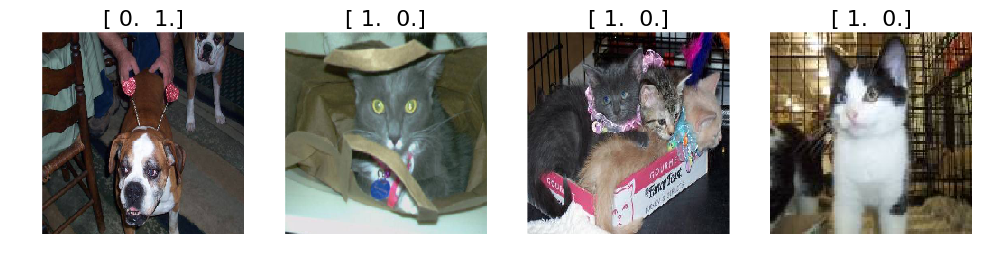

In [10]:
vgg = Vgg16()

batches = vgg.get_batches(path+'train', batch_size=4)
imgs, labels = next(batches)
plots(imgs, titles=labels)

Train the model

In [11]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
20000/20000 [==============================] - 659s - loss: 0.1181 - acc: 0.9689 - val_loss: 0.0518 - val_acc: 0.9842


After finetuning, it's time to generate our predictions for the test set. Opening up one of the images after prediction, it looks like the second column is 'dogs'. 

Found 12500 images belonging to 1 classes.
[[  1.0000e+00   5.2418e-10]
 [  4.4247e-01   5.5753e-01]
 [  1.0000e+00   4.0741e-07]
 [  1.0000e+00   1.5721e-11]
 [  3.6645e-06   1.0000e+00]]
12500
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


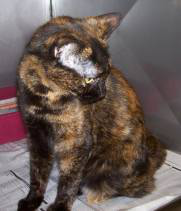

In [14]:
batches, preds = vgg.test(path+'test', batch_size=batch_size)

print(preds[:5])
print(len(preds))

filenames = batches.filenames
print(filenames[:5])
from PIL import Image
Image.open(path+'test/' + filenames[2])

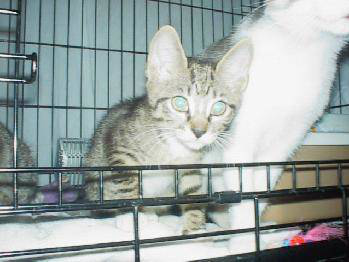

In [30]:
Image.open(path+'test/' + filenames[0])

Every file begins with the file's id. Save out the ids and predictions to a csv for submitting. (dogs are 1, cats are 0). Since there are only two classes, and since cat_prob = 1 - dog_prob, we can just use the dog % predictions directly (column 2). The Kaggle contest uses log loss scoring, so I capped values at 5%-95% to play nice with the peculiarities of log scoring (a 100% on a wrong answer increases the score asymptotically).

In [28]:
import re
import pandas as pd

predictions = np.argmax(preds, axis=1)
df = pd.DataFrame(columns=['id', 'label'])
df.label = np.clip(preds[:,1], .05, .95)
for index, filename in enumerate(filenames):
    #set the id to the opening digit characters of each filename
    df.loc[0,'id'] = int(re.findall('\d+', filename)[0])
    
df.id = df.id.astype('int32')
df = df.set_index('id')

In [41]:
df.to_csv('submit.csv')

## Conclusion

My final score was about .094, putting me at 402 out of 1316. Not amazing, but a top 31% score is satisfactory for now. 


### Ideas for improving: 

more epochs. With 1 epoch my prediction accuracy in the training/validation sets is 98%+, but I could do a few more epochs to see if that helps. 

error analysis. Which images are being incorrectly categorized? In particular, which are given a very high probability score for the wrong category? If there's a pattern to the mistakes, I could get a few thousand more images similar to the wrongly classified images and see if that helps. 

More images in general: I trained off 25,000 images. There's an easily accessable image set of cats and dog pictures. It took about 5 minutes to train on the 25,000 images, so I could conceivably get another 300,000 images to train on for an hour of extra computation time. ($.90 on AWS)

the VGG architecture is a little out of date at this point. A much higher score might require a better CNN architecture. If I attempt to raise my score from here, I don't intend to use VGG. 